Code for project 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

$\mathcal{IRENE'S \quad BLOCKS}$

Plot of the variables: High, Low, Close

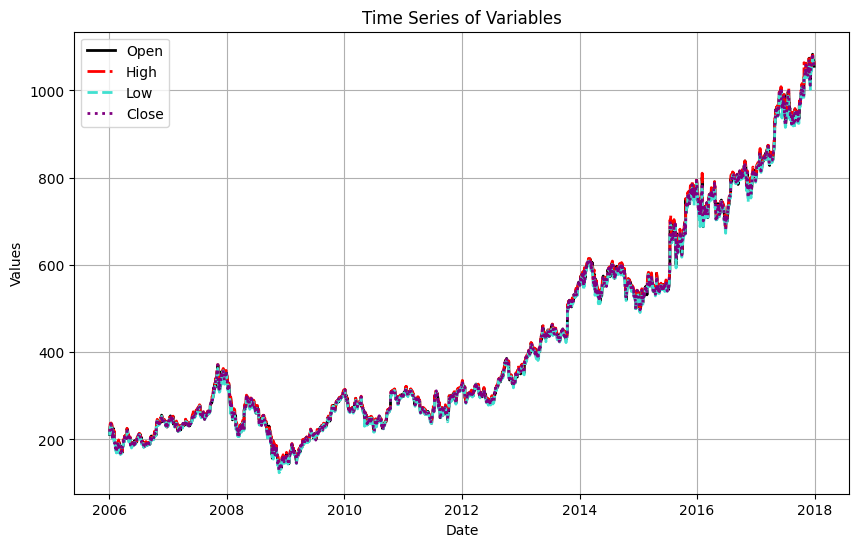

In [2]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)
Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

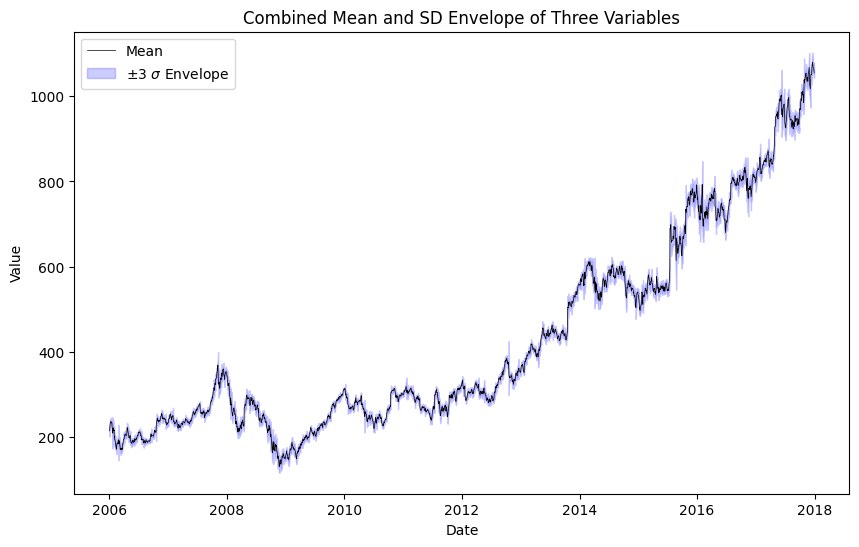

In [3]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,  
    mean_all + 3*std_dev_all,  
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

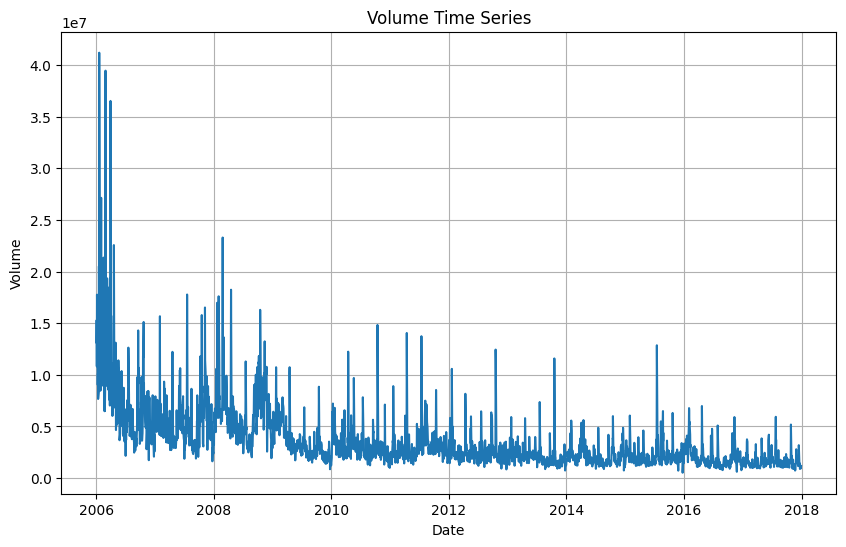

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Series')
plt.grid(True)
plt.savefig("Volume Time Series.png")
plt.show()

Seasonal Trent decomposition using LOESS (STL)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")


Seasonal Trend Decomposition


/tmp/ipykernel_29567/2216483787.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Open"] = data["Open"].fillna(method='ffill')


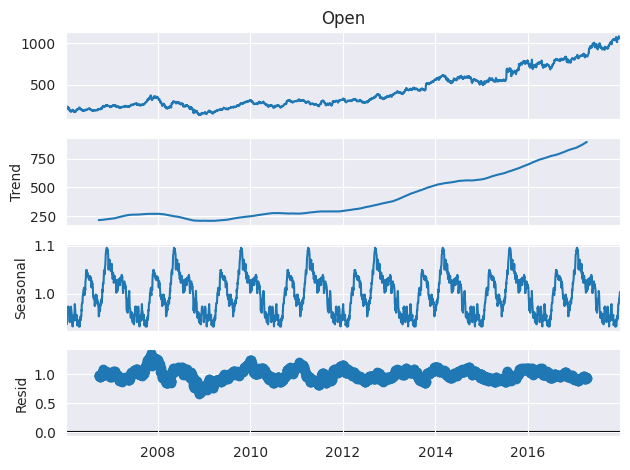

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose


data["Open"] = data["Open"].fillna(method='ffill')
data["Open"].index = pd.to_datetime(data.index)
data["Open"] = data["Open"].asfreq('B')

# daily seasonality
result = seasonal_decompose(data["Open"], model='multiplicative', period=365)
result.plot()
plt.show()


/tmp/ipykernel_29567/3149661141.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Close"] = data["Close"].fillna(method='ffill')


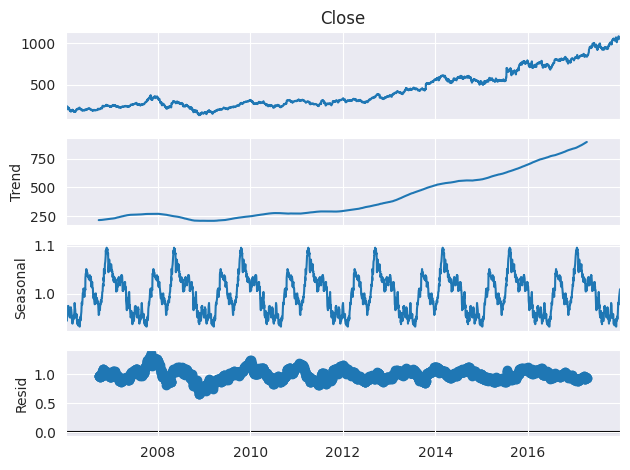

In [7]:
data["Close"] = data["Close"].fillna(method='ffill')
data["Close"].index = pd.to_datetime(data.index)
data["Close"] = data["Close"].asfreq('B')

# daily seasonality
result = seasonal_decompose(data["Close"], model='multiplicative', period=365)
result.plot()
plt.show()

/tmp/ipykernel_29567/2337244148.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["High"] = data["High"].fillna(method='ffill')


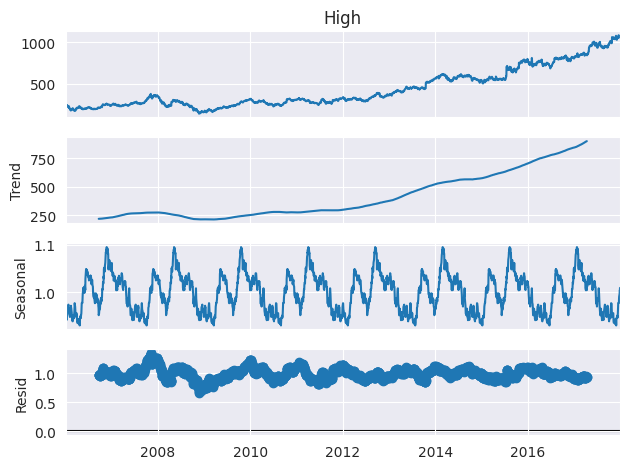

In [8]:
data["High"] = data["High"].fillna(method='ffill')
data["High"].index = pd.to_datetime(data.index)
data["High"] = data["High"].asfreq('B')

# daily seasonality
result = seasonal_decompose(data["High"], model='multiplicative', period=365)
result.plot()
plt.show()

/tmp/ipykernel_29567/4182508684.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Volume"] = data["Volume"].fillna(method='ffill')


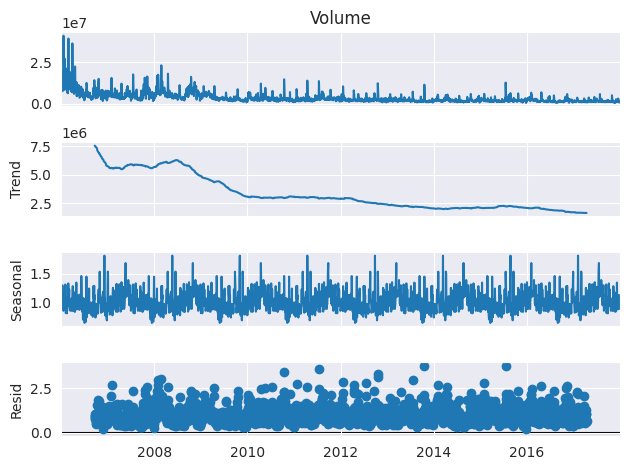

In [9]:
data["Volume"] = data["Volume"].fillna(method='ffill')
data["Volume"].index = pd.to_datetime(data.index)
data["Volume"] = data["Volume"].asfreq('B')

# daily seasonality
result = seasonal_decompose(data["Volume"], model='multiplicative', period=365)
result.plot()
plt.show()

/tmp/ipykernel_29567/3879153365.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Low"] = data["Low"].fillna(method='ffill')


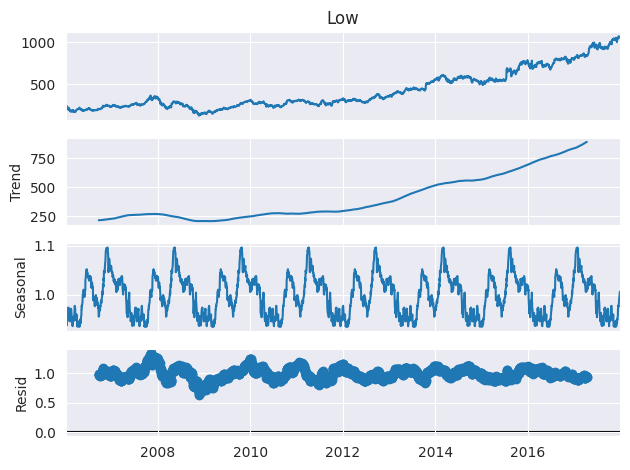

In [10]:
data["Low"] = data["Low"].fillna(method='ffill')
data["Low"].index = pd.to_datetime(data.index)
data["Low"] = data["Low"].asfreq('B')

# daily seasonality
result = seasonal_decompose(data["Low"], model='multiplicative', period=365)
result.plot()
plt.show()

Anton's blocks: added alternate visualisation of stock price over time and volume traded per price graph

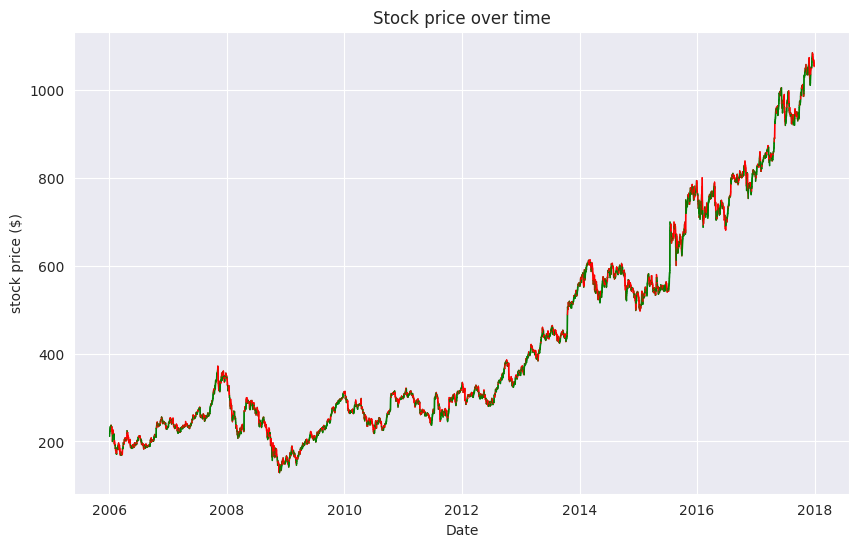

In [11]:
Open = data['Open']
Close=data['Close']

Volume=data['Volume']

plt.figure(figsize=(10, 6))

# Loop through the data and plot in different colors based on the condition
for i in range(1, len(data)):

    date_current = data.index[i-1:i+1]

    # Choose color based on condition
    if Close.iloc[i] > Open.iloc[i]:
        color = 'green'
    else:
        color = 'red'
    
    # Plot the segments with the chosen color
    plt.plot(date_current, [Open.iloc[i-1], Open.iloc[i]], color=color, linestyle='-', linewidth=1)
    plt.plot(date_current, [Close.iloc[i-1], Close.iloc[i]], color=color, linestyle='-', linewidth=1)

plt.xlabel('Date')
plt.ylabel('stock price ($)')
plt.title('Stock price over time')
plt.grid(True)
plt.show()

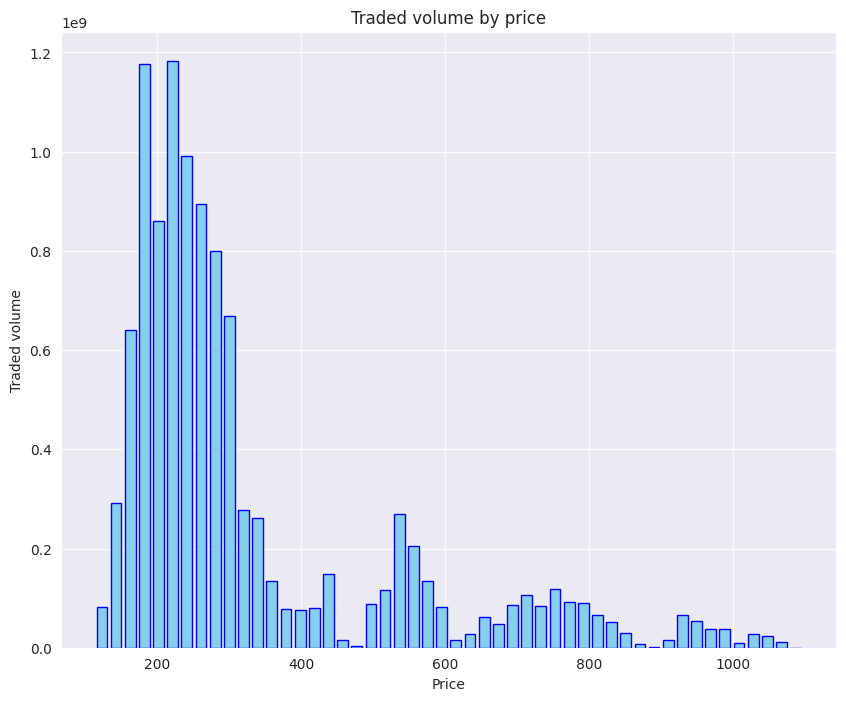

In [12]:
import numpy as np

num_bins = 50 # Number of bins

# Define price bins based on high and low price
price_min = data['Low'].min()
price_max = data['High'].max()
bins = np.linspace(price_min, price_max, num_bins)

# Calculate the midpoints of the bins for plotting

# Calculate the volume in each price bin
volume_by_price = np.zeros(len(bins))

for i in range(len(bins)-1):
    mask = (Close >= bins[i]) & (Close < bins[i + 1])
    volume_by_price[i] = Volume[mask].sum()

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Create a horizontal bar chart for volume by price
ax.bar(bins, volume_by_price, align='center', color='skyblue', edgecolor='blue', width=15)
ax.set_xlabel('Price')
ax.set_ylabel('Traded volume')
ax.set_title('Traded volume by price')
plt.savefig("Traded volume by price.png")
plt.show()

Autocorrelation analysis

            0        1        2        3           4
0      211.47   218.05   209.32   217.83  13137450.0
1      222.17   224.70   220.09   222.84  15292353.0
2      223.22   226.00   220.97   225.85  10815661.0
3      228.66   235.49   226.85   233.06  17759521.0
4      233.44   236.94   230.70   233.68  12795837.0
...       ...      ...      ...      ...         ...
3014  1070.00  1071.72  1067.64  1068.86    889446.0
3015  1068.64  1068.86  1058.64  1065.85    918767.0
3016  1066.60  1068.27  1058.38  1060.20   1116203.0
3017  1062.25  1064.84  1053.38  1055.95    994249.0
3018  1055.49  1058.05  1052.70  1053.40   1180340.0

[3019 rows x 5 columns]
          0         1         2         3         4
0  1.000000  0.999894  0.999841  0.999742 -0.443155
1  0.999894  1.000000  0.999827  0.999866 -0.440717
2  0.999841  0.999827  1.000000  0.999896 -0.447781
3  0.999742  0.999866  0.999896  1.000000 -0.444590
4 -0.443155 -0.440717 -0.447781 -0.444590  1.000000


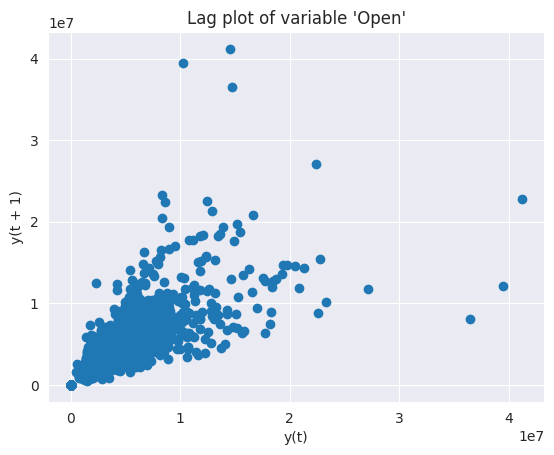

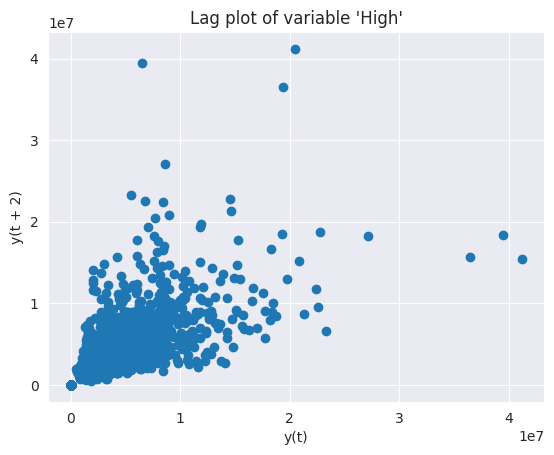

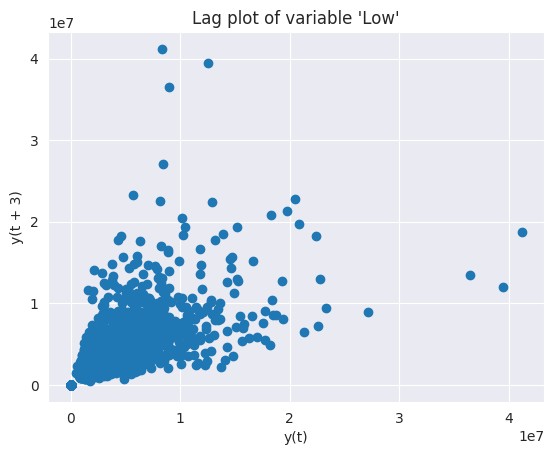

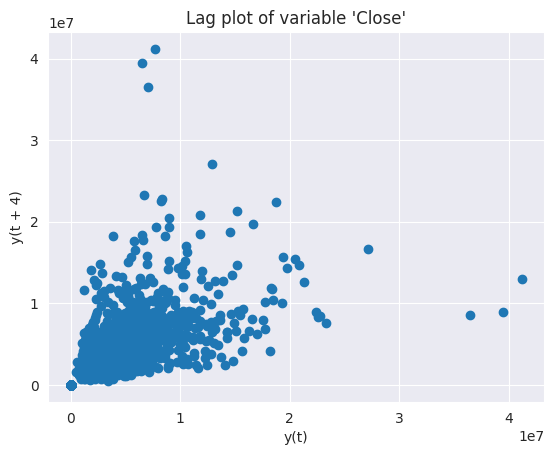

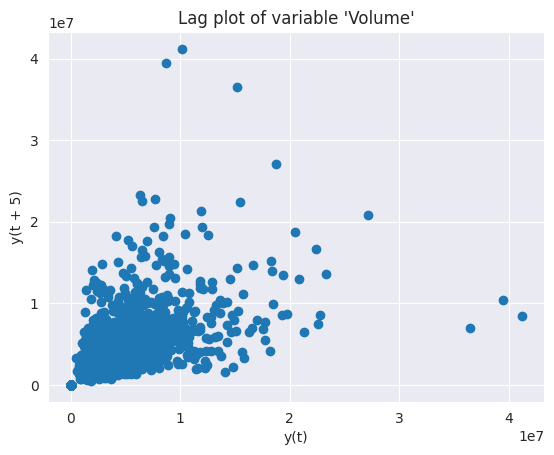

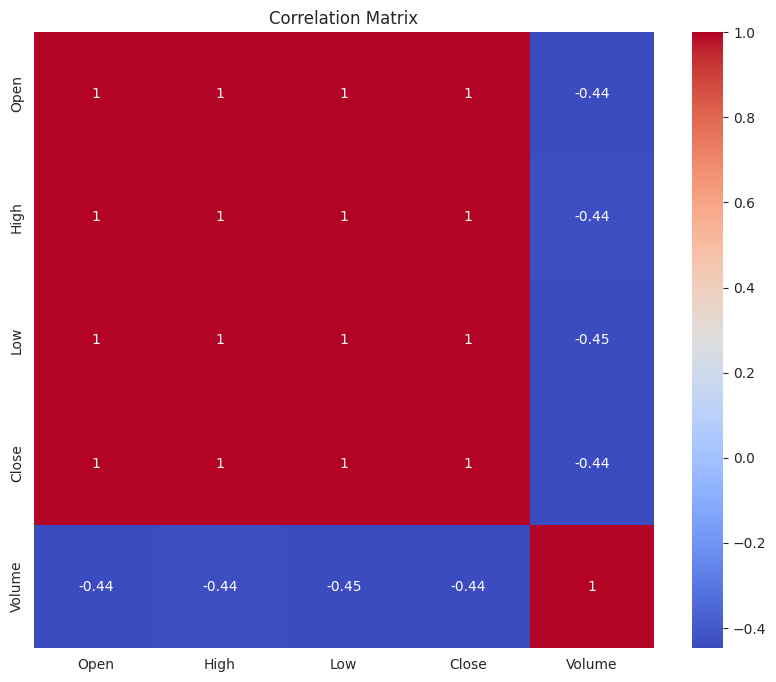

<Figure size 640x480 with 0 Axes>

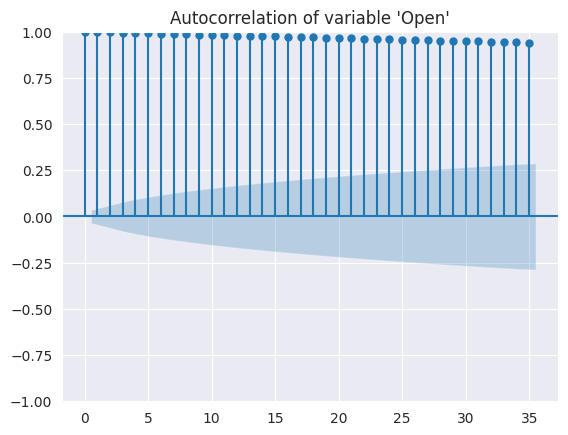

<Figure size 640x480 with 0 Axes>

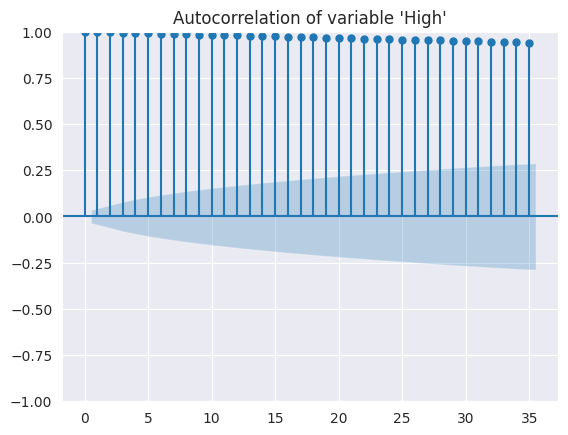

<Figure size 640x480 with 0 Axes>

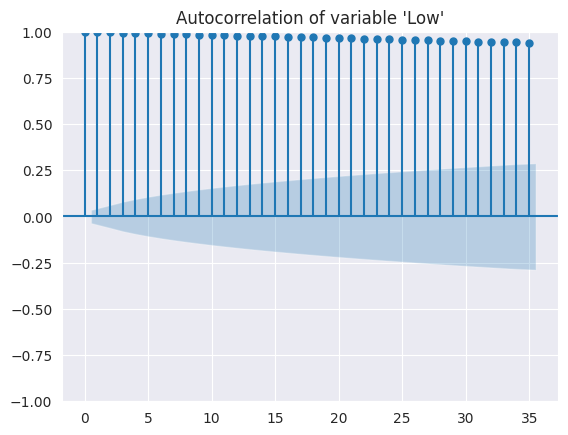

<Figure size 640x480 with 0 Axes>

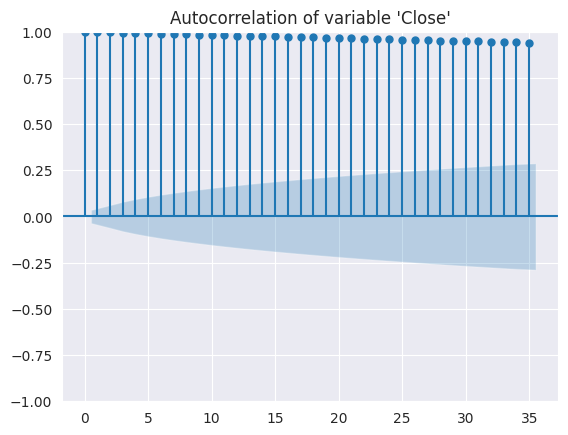

<Figure size 640x480 with 0 Axes>

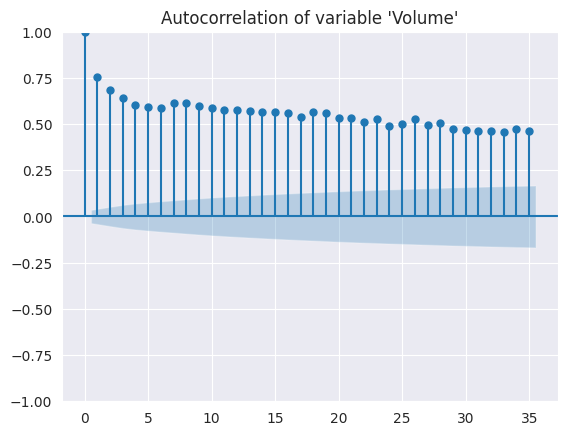

In [13]:
# lagplot
for i in range(5):
    plt.figure()
    pd.plotting.lag_plot(data, lag=i+1)
    plt.title("Lag plot of variable '" + data.columns[i]  + "'")
    plt.savefig("Lag_plot_" + str(i) + ".png")
 
# extracting only the temperature values
values = pd.DataFrame(data.values)
print(values)

# Create correlation matrix
correlation_matrix = values.corr()

# Print the correlation matrix
print(correlation_matrix)

# Optionally, plot the correlation matrix for better visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=data.columns, yticklabels=data.columns)
plt.title("Correlation Matrix")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

for i in range(5):
    plt.figure()
    plot_acf(data.iloc[:, i])
    plt.title("Autocorrelation of variable '" + data.columns[i]  + "'")
    plt.savefig("auc_" + str(i) + ".png")



$\mathbb{Autoregressive \quad part}$

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

2024-11-13 13:32:30.379668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731504750.425338   29567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731504750.439338   29567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 13:32:30.484119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# X should be an ndarray of (N,p) dimension, while Y should be an ndarray of (N,) dimension

T = 10  
data_values = data.values
X = []
Y = []
for t in range(len(data_values) - T):
    x = data_values[t:t+T]  
    X.append(x)
    y = data_values[t+T]     
    Y.append(y)


X = np.array(X)  # (number of sequences, T, 5)
Y = np.array(Y)  # (number of sequences, 5)


print("X.shape:", X.shape)  # Expected shape: (3009, 10, 5) if T=10
print("Y.shape:", Y.shape)  # Expected shape: (3009, 5)
N=len(X)

X.shape: (3009, 10, 5)
Y.shape: (3009, 5)


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam
# Adjust input shape to match (time_steps, features) -> (10, 5)
input_shape = (10, 5)
i = Input(shape=input_shape)

# Example model with an LSTM layer
x = LSTM(50)(i)        # LSTM layer to process sequences
x = Dense(1)(x)        # Output layer (can adjust output neurons if needed)

model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1)
)

# Train the model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

print("Training complete.")

2024-11-13 13:32:34.739875: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 7243128373248.0000 - val_loss: 1112166891520.0000
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7816344502272.0000 - val_loss: 1112114069504.0000
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7127564812288.0000 - val_loss: 1112060985344.0000
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7235275063296.0000 - val_loss: 1112008556544.0000
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7848917991424.0000 - val_loss: 1111955341312.0000
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7167026397184.0000 - val_loss: 1111902912512.0000
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7237535793152.0000 - val_loss: 1111850090496.0000
Epoch 8/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7797648392192.0000 - val_loss: 1111797006336.0000
Epoch 9/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7444114178048.0000 - val_loss: 1111744053248.0000
Epoch 10/80
47/47 ━

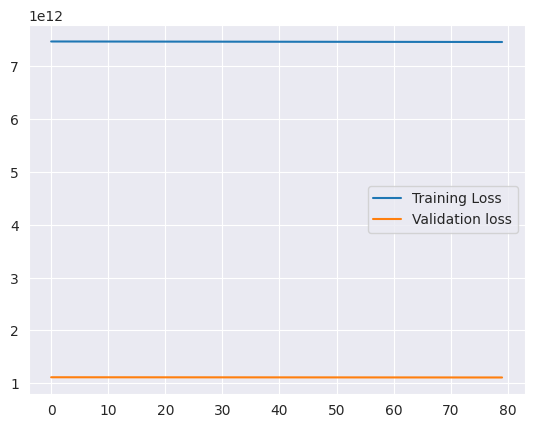

In [17]:
# Plot loss per iteration
plt.plot(r.history["loss"], label="Training Loss")
plt.plot(r.history["val_loss"], label="Validation loss")
plt.legend()

In [18]:
# Forecast future values
validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0, 0] # 1x1 array
  
  # Update predictions list
  validation_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1) # shift everything one spot to the left, we replace it with the latest forecasted prediction. Multi-step predictions.
  last_x[-1] = p

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 10, 5), found shape=(1, 50)

In [ ]:
plt.plot(validation_target, label="forecast_target")
plt.plot(validation_predictions, label="forecast_prediction")
plt.legend()